In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import fitsio
import glob

import numpy as np
import healpy as hp
import xlens
import treecorr
import astropy.io.ascii as pyascii
import numpy.lib.recfunctions as rfn
from lsst.geom import degrees

from lsst.daf.butler import Butler
from lsst.skymap.ringsSkyMap import RingsSkyMap, RingsSkyMapConfig

In [31]:
clusters = pyascii.read("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/camira/camira_s23b_wide_v3.csv")
clusters = clusters[(clusters["N_mem"] > 12) & (clusters["z_cl"] < 1.5)]
cor1 = treecorr.NGCorrelation(nbins=20, min_sep=0.25, max_sep=360.0, sep_units="arcmin")
cor2 = treecorr.NKCorrelation(nbins=20, min_sep=0.25, max_sep=360.0, sep_units="arcmin")
cat0 = treecorr.Catalog(
    ra=clusters["ra"],
    dec=clusters["dec"],
    ra_units="deg",
    dec_units="deg",
)
cate = treecorr.Catalog(
    g1=data["e1"] * data["wsel"],
    g2=-data["e2"] * data["wsel"],
    ra=data["ra"],
    dec=data["dec"],
    ra_units="deg",
    dec_units="deg",
)
catk = treecorr.Catalog(
    k=res,
    ra=data["ra"],
    dec=data["dec"],
    ra_units="deg",
    dec_units="deg",
)

cor1.process(cat0, cate)
cor2.process(cat0, catk)

In [23]:
if False:
    # Set up the configuration
    config = RingsSkyMapConfig()
    config.numRings = 120
    config.projection = "TAN"
    config.tractOverlap = 1.0 / 60  # degrees
    config.pixelScale = 0.168  # arcsec/pixel
    skymap = RingsSkyMap(config)
    
    # example list of tracts
    tract_list = fitsio.read("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/tracts_id.fits")
    ra = np.zeros(len(tract_list))
    dec = np.zeros(len(tract_list))
    for i, tractId in enumerate(tract_list):
        # get the TractInfo for this tract
        tractInfo = skymap[tractId]
        # pull out its WCS and bounding box
        wcs  = tractInfo.getWcs()
        bbox = tractInfo.getBBox()
        ra_deg, dec_deg = wcs.pixelToSky(
            bbox.getCenter()
        ).getPosition(degrees)
        ra[i] = ra_deg
        dec[i] = dec_deg
    dd = np.zeros(len(tract_list), dtype=[("tract", "i4"), ("ra", "f8"), ("dec", "f8")])
    dd["tract"] = tract_list
    dd["ra"] = ra
    dd["dec"] = dec
    fitsio.write("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/tracts.fits", dd)
else:
    dd = fitsio.read("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/tracts.fits")

In [10]:
# Set up the configuration
config = RingsSkyMapConfig()
config.numRings = 120
config.projection = "TAN"
config.tractOverlap = 1.0 / 60  # degrees
config.pixelScale = 0.168  # arcsec/pixel
skymap = RingsSkyMap(config)

# example list of tracts
tract_list = fitsio.read("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/tracts_id.fits")
ra = np.zeros(len(tract_list))
dec = np.zeros(len(tract_list))
# get the TractInfo for this tract
tractInfo = skymap[0]
bbox = tractInfo.getBBox()

In [14]:
bbox.getDimensions()

Extent2I(36000, 36000)

In [16]:
36000 / 2.0 * 0.168 / 60

50.4

In [64]:
if False:
    frames = pyascii.read("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/frames.csv")
    sel = ((frames["filter"] == "HSC-I") | (frames["filter"] == "HSC-I2")) & (np.abs(frames["ccd"] -49.5) < 0.6)
    frames = frames[sel]
    NSIDE = 1024
    visits = frames['visit']
    ccds   = frames['ccd']
    
    # 1) find all visits that have at least one ccd==49 and one ccd==50
    vis_with_49 = np.unique(visits[ccds == 49])
    vis_with_50 = np.unique(visits[ccds == 50])
    common_visits = np.intersect1d(vis_with_49, vis_with_50)
    
    # 2) build masks for those visits, split by ccd
    mask_common = np.isin(visits, common_visits)
    mask49 = mask_common & (ccds == 49)
    mask50 = mask_common & (ccds == 50)
    
    frames_49 = frames[mask49]
    frames_50 = frames[mask50]
    
    frames_49 = frames_49[np.argsort(frames_49["visit"])]
    frames_50 = frames_50[np.argsort(frames_50["visit"])]
    frames_49["ra"] = (frames_50["ra"] + frames_49["ra"]) / 2.0
    frames_49["dec"] = (frames_50["dec"] + frames_49["dec"]) / 2.0
    
    
    mask = hp.read_map("fdfc_hp_window.fits", nest=True, dtype=bool)
    theta = np.deg2rad(90.0 - frames_49["dec"])
    phi = np.deg2rad(frames_49["ra"])
    
    # Convert to HEALPix pixel indices (in NESTED ordering)
    pix = hp.ang2pix(NSIDE, theta, phi, nest=True)
    mm = mask[pix]
    frames_49 = frames_49[mm]
    frames = frames_49
    fitsio.write("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/visits.fits", frames_49.to_pandas().to_records())
else:
    frames = fitsio.read("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/visits.fits")

In [66]:
len(frames)

5047

In [69]:
frames.dtype.names

('index', 'visit', 'ccdtemp', 'ra', 'dec', 'seeing', 'ccd', 'filter')

In [72]:
frames["seeing"]

array([0.43558064, 0.4304445 , 0.39591065, ..., 0.56409186, 0.5612566 ,
       0.6109562 ], dtype='>f8')

In [4]:
# Create x, y, yerr for all 8 plots
x_data = []
y_data = []
y_errs = []

def compute_xy(data_subset):
    arr = np.average(data_subset, axis=0)
    x  = arr[0]
    y1 = arr[1] / arr[3]
    y2 = arr[2] / arr[3]
    return x, y1, y2

for ff in ["cluster", "visit", "tract"]:
    data = fitsio.read(f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal3/NG_{ff}.fits")

    # get the “nominal” values
    x, y1, y2 = compute_xy(data)
    
    # ---- bootstrap parameters ----
    nboot = 1000                      # number of bootstrap samples
    nreal = data.shape[0]             # how many realizations you have
    
    # pre-allocate arrays to hold each trial
    y1_boot = np.empty((nboot, y1.size))
    y2_boot = np.empty((nboot, y2.size))
    
    # ---- run the bootstrap ----
    for i in range(nboot):
        # sample `nreal` indices with replacement
        idx = np.random.choice(nreal, size=nreal, replace=True)
        # compute ratios on that resampled set
        _, y1_i, y2_i = compute_xy(data[idx])
        y1_boot[i] = y1_i
        y2_boot[i] = y2_i
    
    # ---- compute the 1-σ errors ----
    y1_err = np.std(y1_boot, axis=0)
    y2_err = np.std(y2_boot, axis=0)

    x_data.extend([x, x])
    y_data.extend([y1, y2])
    y_errs.extend([y1_err, y2_err])

In [76]:
np.average(data[:, -1])

44039.51535150753

In [5]:
import scipy

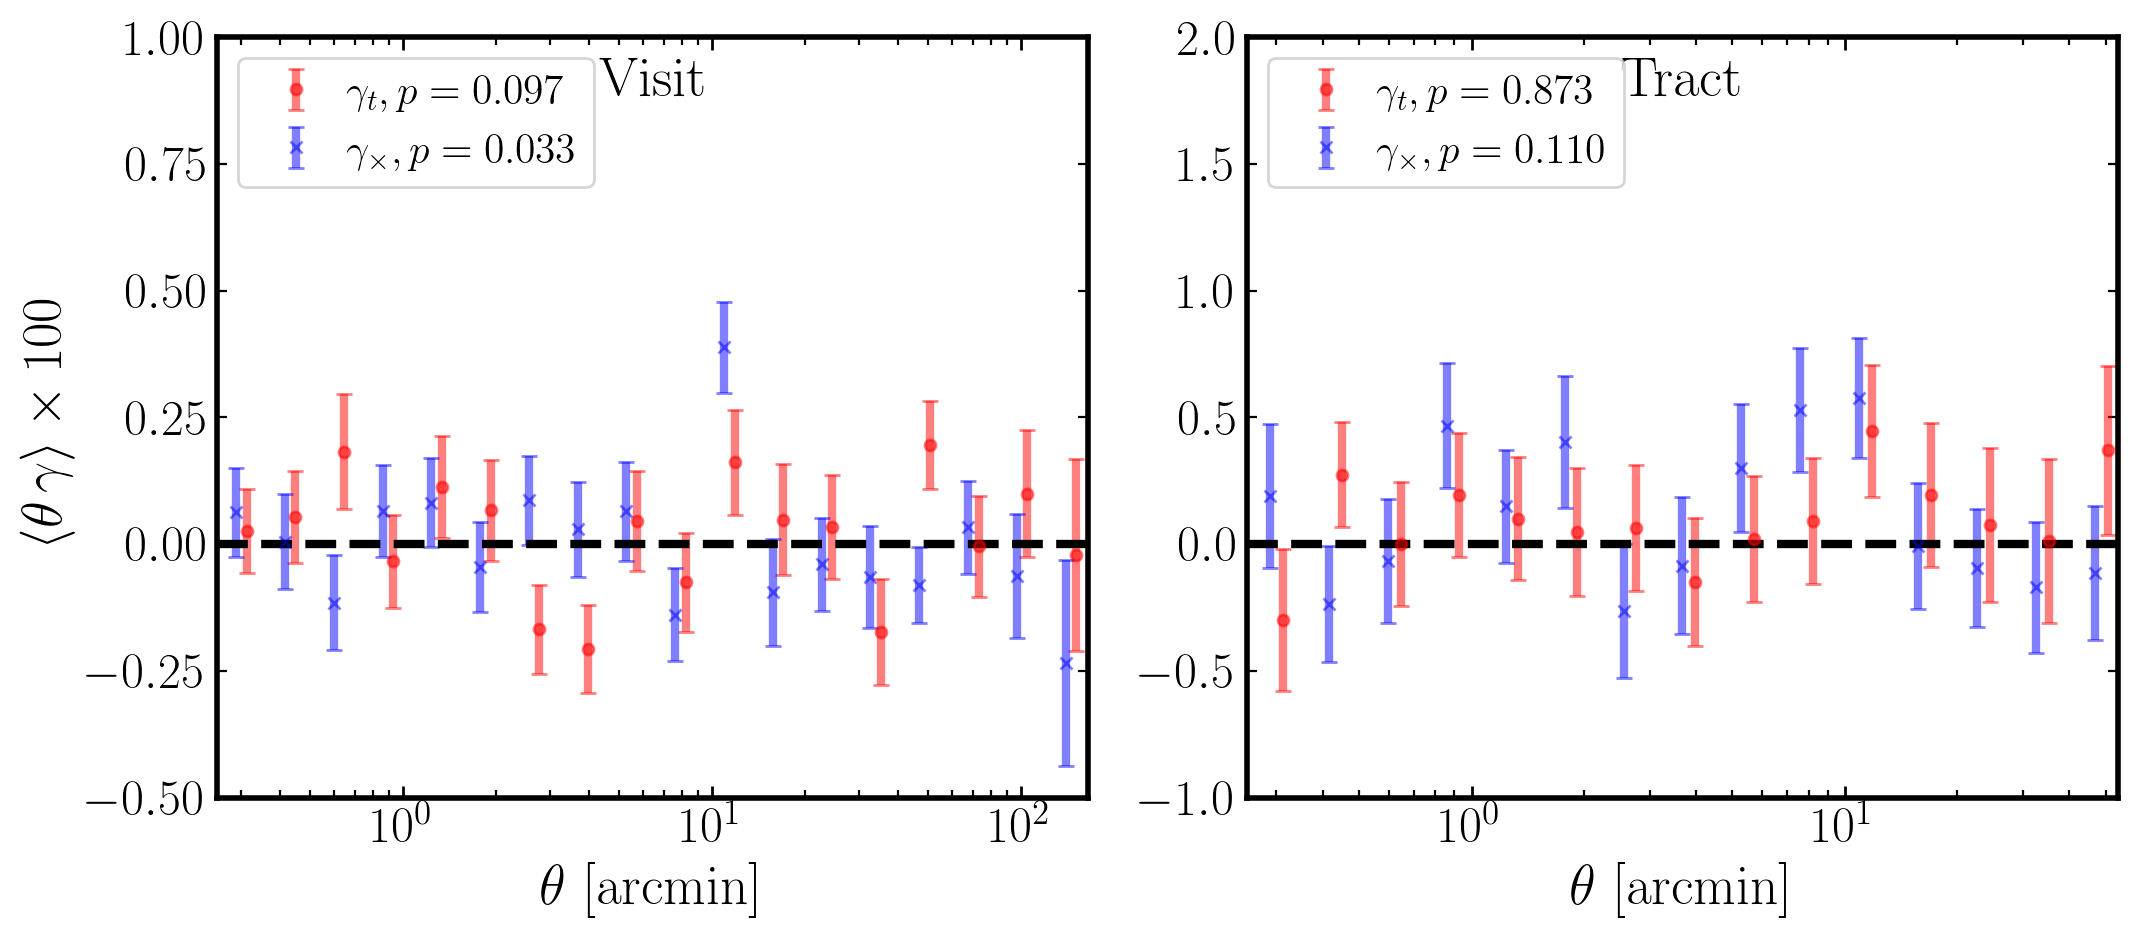

In [175]:
multiply = 100
plt.close()

_, axes = plt.subplots(1, 2, figsize=(11, 5))
ax = axes[0]
i = 2
tmax = 18
chi2 = np.sum((y_data[i][0:tmax] / y_errs[i][0:tmax]) ** 2.0)
df = len(y_data[i][0:tmax])
pv = scipy.stats.chi2.sf(chi2, df)
ax.errorbar(
    x_data[i] * 1.04, 
    y_data[i] * x_data[i] * multiply, 
    y_errs[i] * x_data[i] * multiply,
    fmt='o', ms=4, capsize=3, linestyle='', alpha=0.5, 
    color="red",
    label=r"$\gamma_t, p =%.3f$" % (pv),
)

i = 3
chi2 = np.sum((y_data[i][0:tmax] / y_errs[i][0:tmax]) ** 2.0)
df = len(y_data[i][0:tmax])
pv = scipy.stats.chi2.sf(chi2, df)
ax.errorbar(
    x_data[i]/1.04, 
    y_data[i] * x_data[i] * multiply, 
    y_errs[i] * x_data[i] * multiply,
    fmt='x', ms=4, capsize=3, linestyle='', alpha=0.5, 
    color="blue", 
    label=r"$\gamma_\times, p =%.3f$" % (pv),
)
ax.set_xlim(0.25, 165)
ax.set_xscale('log')
ax.legend(fontsize=15, loc="upper left", handletextpad=0.2)
ax.axhline(0.0, ls='--', color='black')
ax.set_title("Visit", y=0.90)
ax.set_xlabel(r"$\theta\ \mathrm{[arcmin]}$")
ax.set_ylabel(r"$\langle \theta\,\gamma \rangle \times 100$")
ax.set_ylim(-0.5, 1)

ax = axes[1]
i = 4
chi2 = np.sum((y_data[i][0:-3] / y_errs[i][0:-3]) ** 2.0)
df = len(y_data[i][0:-3])
pv = scipy.stats.chi2.sf(chi2, df)
ax.errorbar(
    x_data[i]* 1.04, 
    y_data[i] * x_data[i] * multiply, 
    y_errs[i] * x_data[i] * multiply,
    fmt='o', ms=4, capsize=3, linestyle='', alpha=0.5, 
    color="red",
    label=r"$\gamma_t, p=%.3f$" % (pv),
)
i = 5
chi2 = np.sum((y_data[i][0:15] / y_errs[i][0:15]) ** 2.0)
df = len(y_data[i][0:15])
pv = scipy.stats.chi2.sf(chi2, df)
ax.errorbar(
    x_data[i]/1.04, 
    y_data[i] * x_data[i] * multiply, 
    y_errs[i] * x_data[i] * multiply,
    fmt='x', ms=4, capsize=3, linestyle='', alpha=0.5,
    color="blue",
    label=r"$\gamma_\times, p=%.3f$" % (pv),
)
ax.set_xscale('log')
ax.legend(fontsize=15, loc="upper left", handletextpad=0.2)
ax.set_xlim(0.25, 54)
ax.set_ylim(-1.0, 2)
ax.axhline(0.0, ls='--', color='black')
ax.set_title("Tract", y=0.90)
ax.set_xlabel(r"$\theta\ \mathrm{[arcmin]}$")

plt.tight_layout()
plt.show()

In [197]:
dd = fitsio.read("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal3/NG_visit_recheck.fits")
#msk = np.abs(dd[:, 0]) > 1e-8
#dd = dd[msk]

In [198]:
dd.shape

(317686, 4)

(array([1.72000e+02, 2.06000e+02, 2.45000e+02, 2.44000e+02, 2.86000e+02,
        3.79000e+02, 4.52000e+02, 5.37000e+02, 5.87000e+02, 7.66000e+02,
        9.28000e+02, 1.09800e+03, 1.27600e+03, 1.68100e+03, 1.95700e+03,
        2.33300e+03, 2.76500e+03, 3.38600e+03, 4.01800e+03, 4.75100e+03,
        5.84600e+03, 7.02700e+03, 8.52400e+03, 1.03790e+04, 1.19850e+04,
        1.83002e+05, 1.03350e+04, 8.30200e+03, 7.05600e+03, 5.89200e+03,
        4.82000e+03, 4.03300e+03, 3.38300e+03, 2.87800e+03, 2.42400e+03,
        1.96100e+03, 1.61000e+03, 1.38100e+03, 1.19500e+03, 9.22000e+02,
        7.76000e+02, 6.69000e+02, 5.20000e+02, 4.73000e+02, 3.75000e+02,
        3.21000e+02, 2.89000e+02, 2.43000e+02, 1.97000e+02, 1.70000e+02]),
 array([-4.  , -3.84, -3.68, -3.52, -3.36, -3.2 , -3.04, -2.88, -2.72,
        -2.56, -2.4 , -2.24, -2.08, -1.92, -1.76, -1.6 , -1.44, -1.28,
        -1.12, -0.96, -0.8 , -0.64, -0.48, -0.32, -0.16,  0.  ,  0.16,
         0.32,  0.48,  0.64,  0.8 ,  0.96,  1.12,  1.28

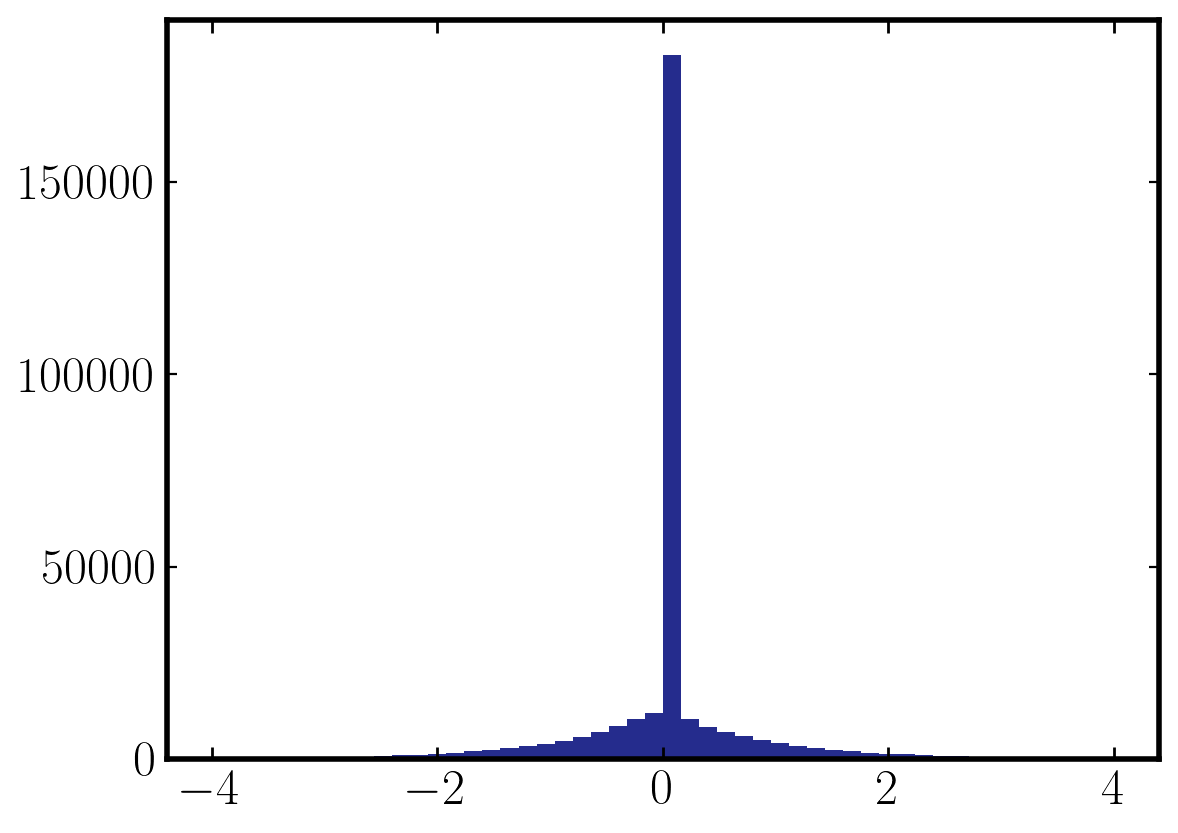

In [199]:
plt.hist(dd[:, 1] * dd[:, 3], bins = 50, range=(-4, 4))

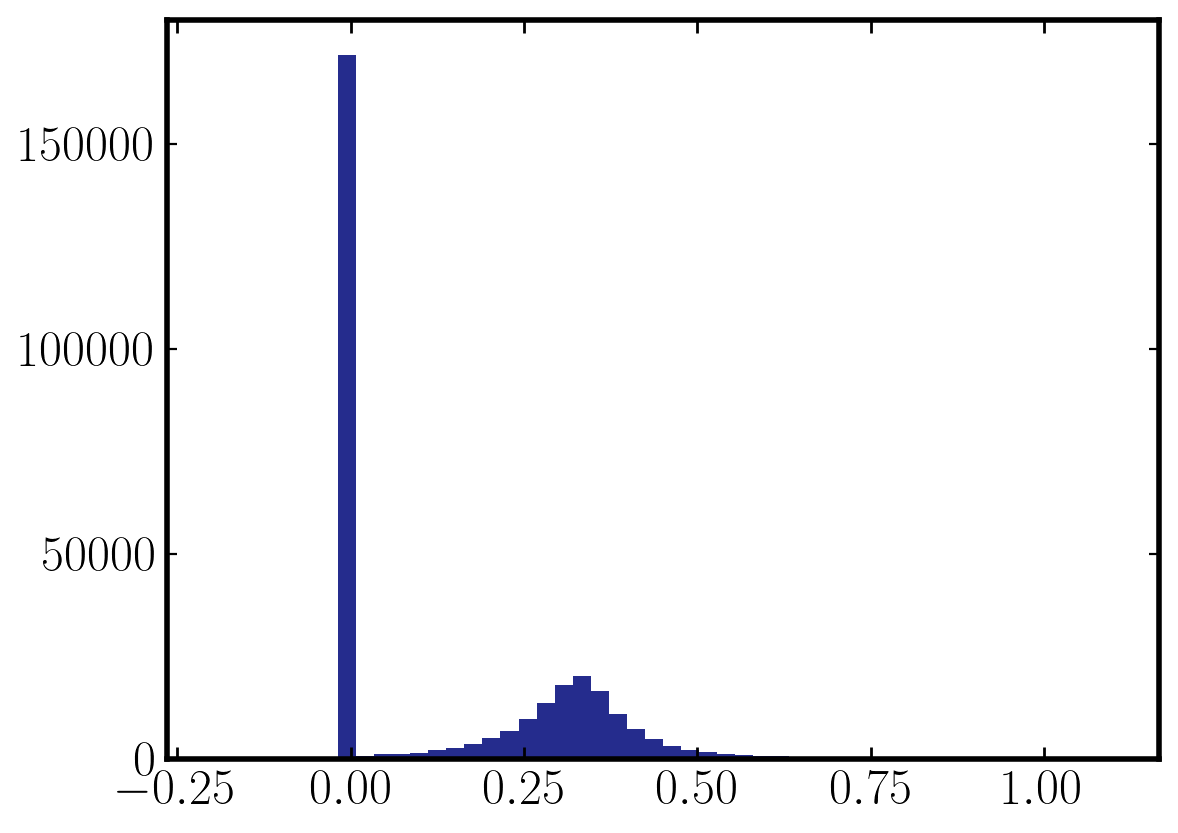

In [200]:
_ = plt.hist(dd[:, 2], bins=50, range=(-0.2, 1.1))

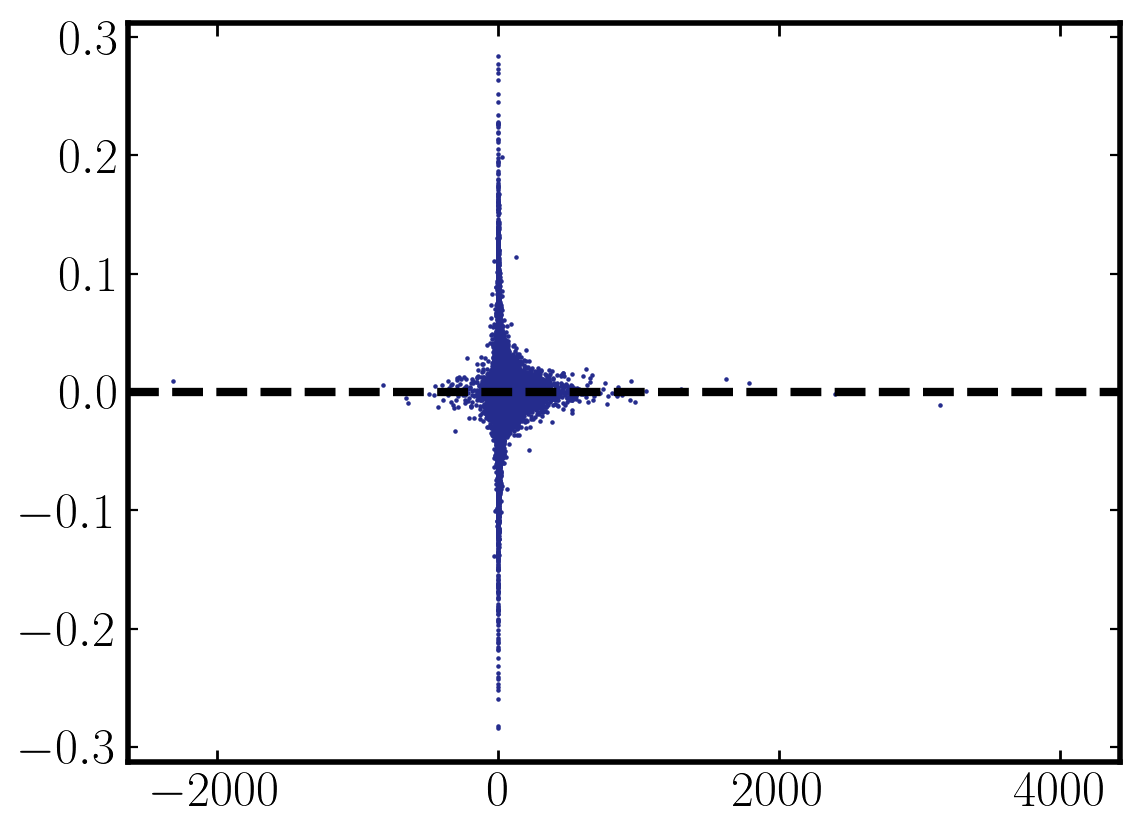

In [201]:
plt.scatter(dd[:, 3] * dd[:, 2], dd[:, 0], s=0.4)
plt.axhline(0.0, color="black", ls="--")

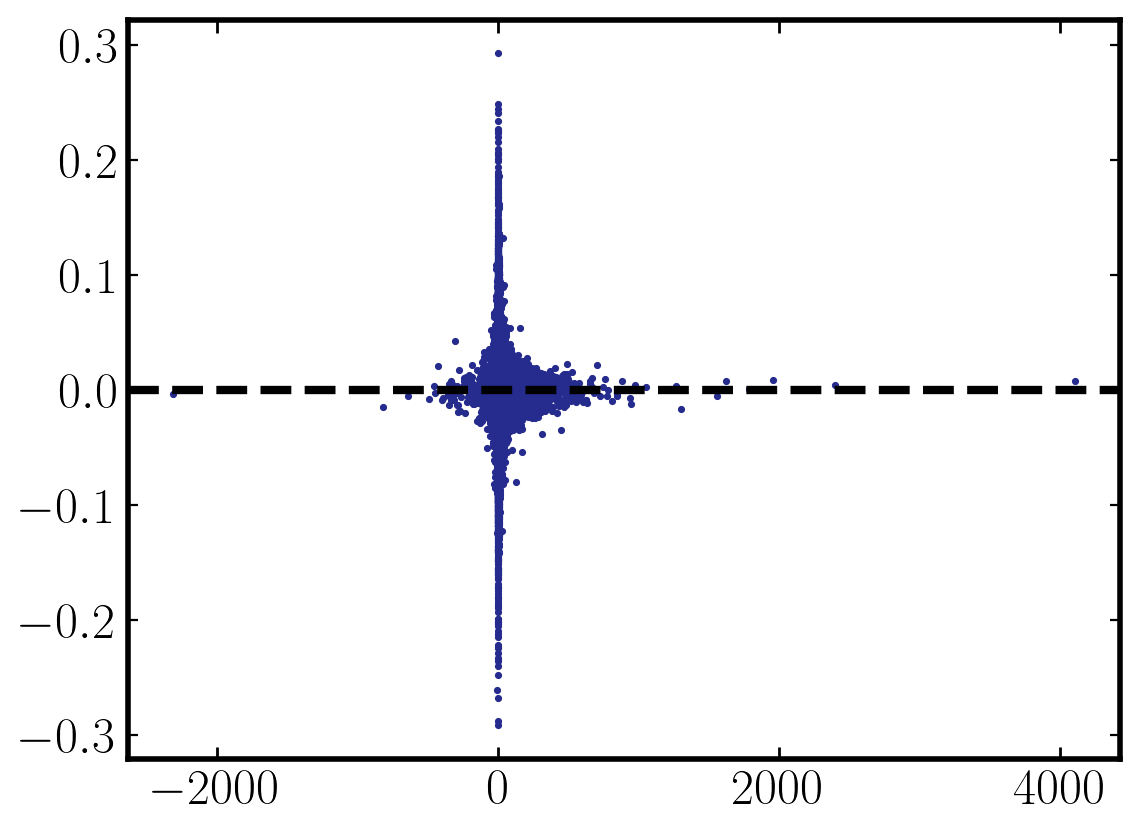

In [202]:
plt.scatter(dd[:, 3] * dd[:, 2], dd[:, 1], s=2.5)
plt.axhline(0.0, color="black", ls="--")

In [206]:
msk = (np.abs(dd[:, 3] * dd[:, 1]) < 4) 
np.sum(dd[:, 1][msk]* dd[:, 3][msk]) / np.sum(dd[:, 3][msk] * dd[:, 2][msk]) * 12

0.0023552646225263327

In [207]:
np.sum(msk)

315055

In [208]:
len(msk)

317686

In [177]:
np.sum(dd[:, 0][msk]* dd[:, 3][msk]) / np.sum(dd[:, 3][msk] * dd[:, 2][msk]) * 12

0.0019099655064408016

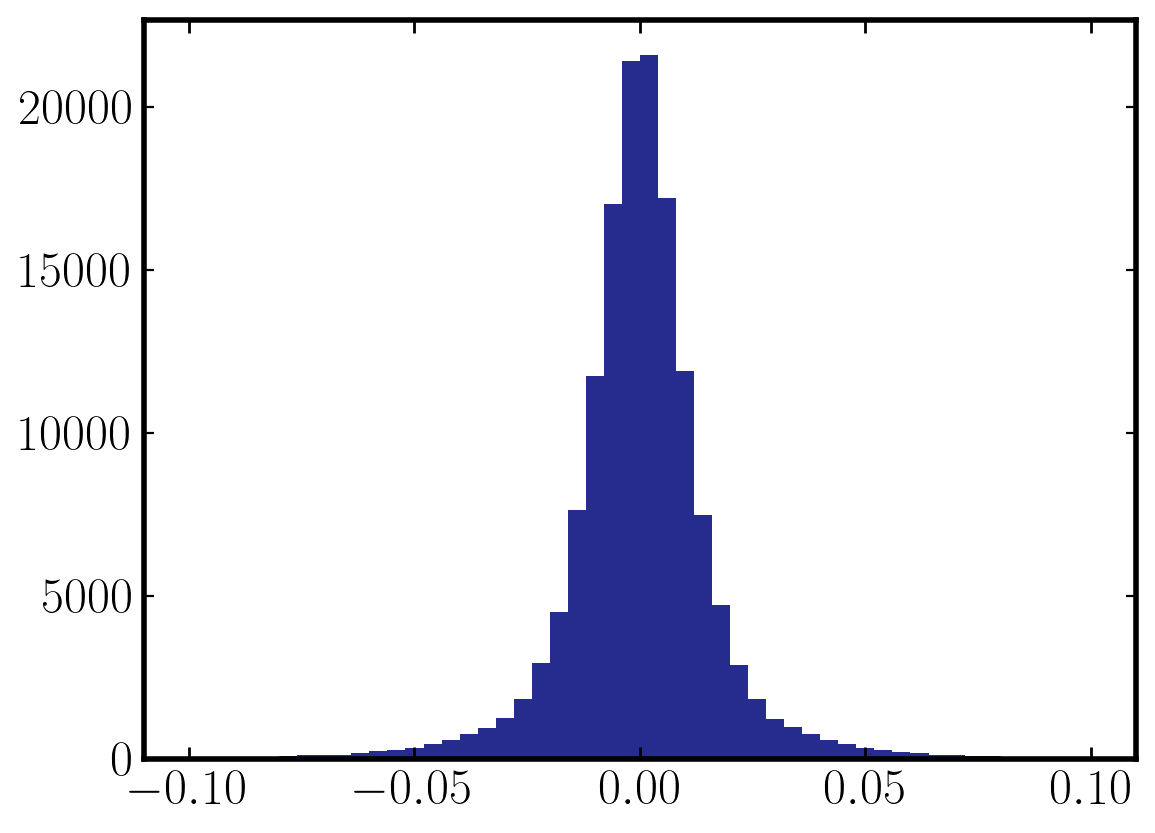

In [85]:
_ = plt.hist(dd[:, 0], bins=50, range=(-0.1, 0.1))

In [111]:
np.average(dd[:, 0][dd[:, 3] * dd[:, 2]<1000]) / 0.2 * 10

0.0036561373042533446

In [114]:
np.average(dd[:, 1][dd[:, 3] * dd[:, 2]<1000]) / 0.2 * 10

0.001736622374775771

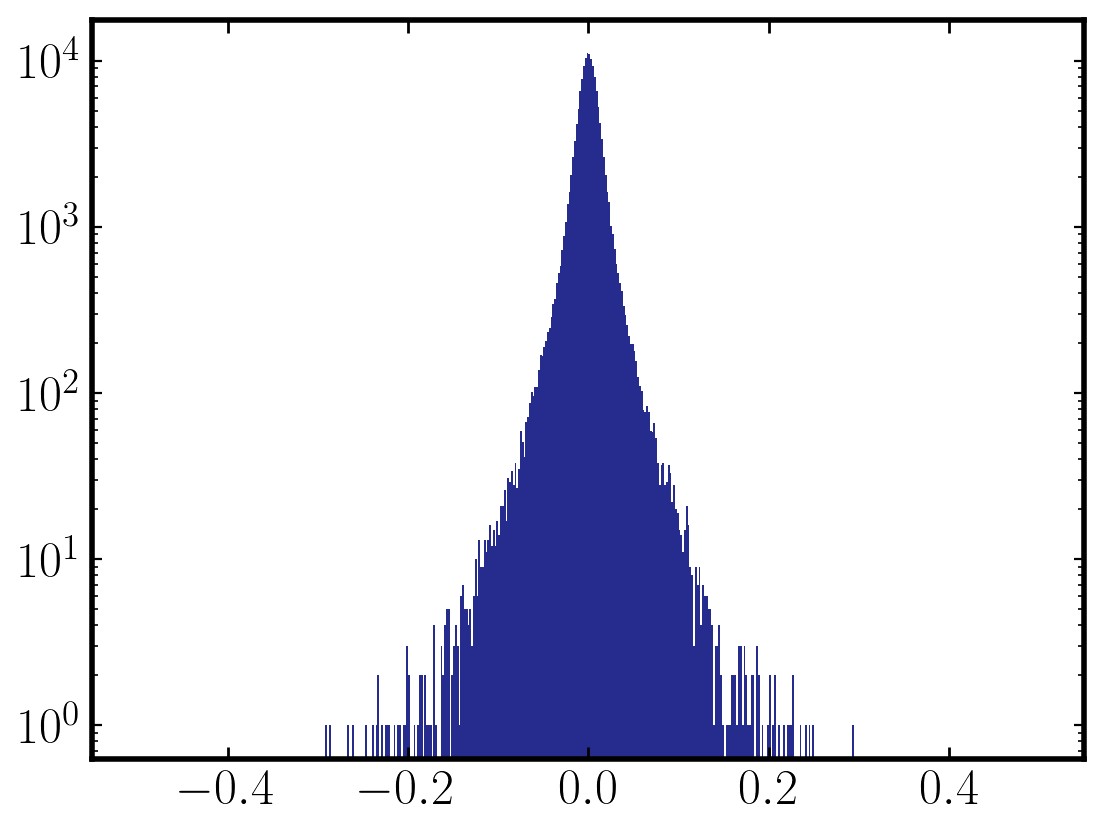

In [59]:
_ = plt.hist(dd[:, 1], bins=500, range=(-0.5, 0.5))
plt.yscale("log")

In [67]:
np.average(dd[:, 1]) / 0.2 * 10

0.0017429979863512778

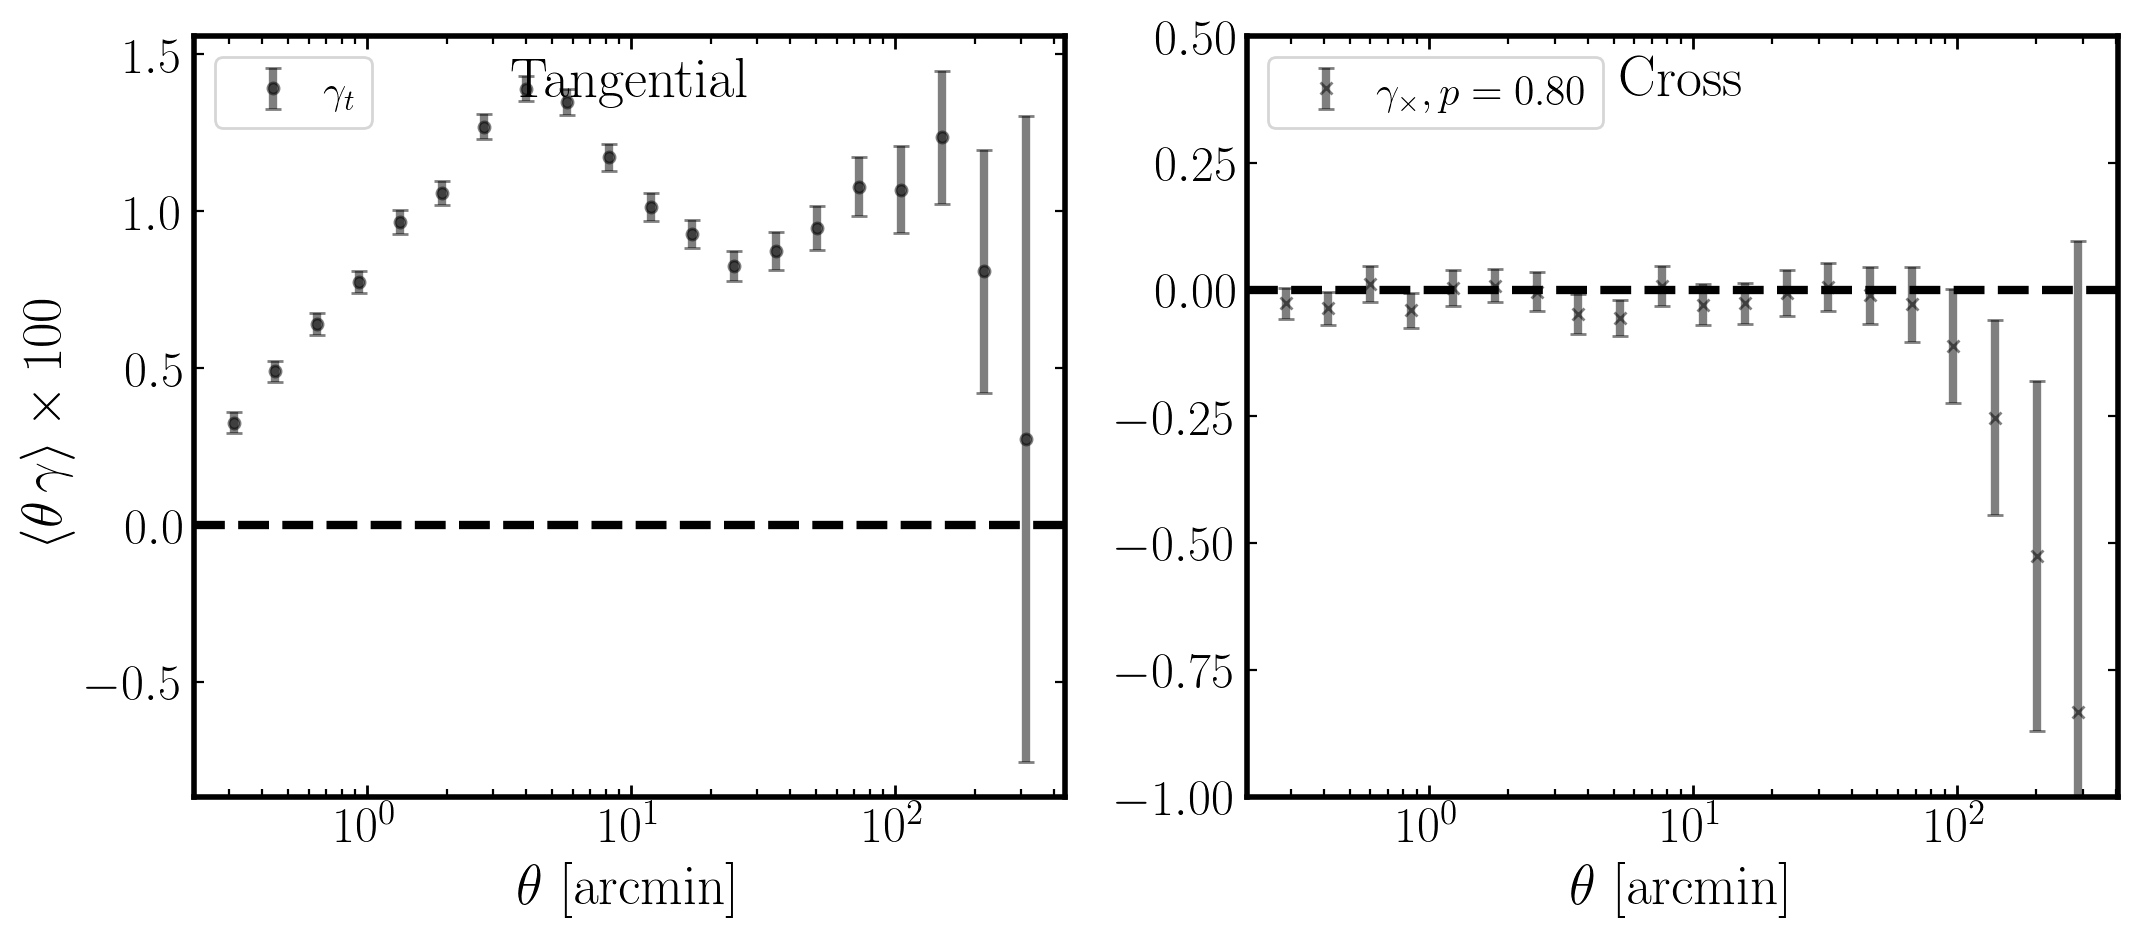

In [8]:
multiply = 100
plt.close()

_, axes = plt.subplots(1, 2, figsize=(11, 5))
ax = axes[0]
i = 0
chi2 = np.sum((y_data[i][0:-3] / y_errs[i][0:-3]) ** 2.0)
df = len(y_data[i][0:-3])
ax.errorbar(
    x_data[i]*1.04, 
    y_data[i] * x_data[i] * multiply, 
    y_errs[i] * x_data[i] * multiply,
    fmt='o', ms=4, capsize=3, linestyle='', alpha=0.5, 
    color="black",
    label=r"$\gamma_t$",
)

ax.set_xscale('log')
ax.legend(fontsize=15, loc="upper left", handletextpad=0.2)
ax.axhline(0.0, ls='--', color='black')
ax.set_title("Tangential", y=0.90)
ax.set_xlabel(r"$\theta\ \mathrm{[arcmin]}$")
ax.set_ylabel(r"$\langle \theta\,\gamma \rangle \times 100$")

ax = axes[1]
i = 1
chi2 = np.sum((y_data[i] / y_errs[i]) ** 2.0)
df = len(y_data[i])
pv = scipy.stats.chi2.sf(chi2, df)
ax.errorbar(
    x_data[i]/1.04, 
    y_data[i] * x_data[i] * multiply, 
    y_errs[i] * x_data[i] * multiply,
    fmt='x', ms=4, capsize=3, linestyle='', alpha=0.5,
    color="black",
    label=r"$\gamma_\times, p =%.2f$" % (pv),
)
ax.set_xscale('log')
ax.legend(fontsize=15, loc="upper left", handletextpad=0.2)
ax.set_ylim(-1, 0.5)
ax.axhline(0.0, ls='--', color='black')
ax.set_title("Cross", y=0.90)
ax.set_xlabel(r"$\theta\ \mathrm{[arcmin]}$")

plt.tight_layout()
plt.show()